In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
# connected=True means it will download the latest version of plotly javascript library.
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Data Preprocessing/myAppleStore_new.csv')

#print(df.dtypes)
#df.loc[df.App=='Tiny Scanner - PDF Scanner App']
# df[df.duplicated(keep='first')]

#df.to_csv('new.csv', sep='\t')
#df = df.drop(columns = 'Index')
df.drop_duplicates(subset='App', inplace=True)
#为方便后续处理，和googleplay保持一致，再添加一栏“type”：当price>0是为paid，否则为free
def label_race(row):
    if row['Price'] != 0:
        return 'Paid'
    else:
        return 'Free'
df['Type'] = df.apply(lambda row:label_race(row),axis = 1)
#df = df[df['Android Ver'] != np.nan]
#df = df[df['Android Ver'] != 'NaN']
#df = df[df['Installs'] != 'Free']
#df = df[df['Installs'] != 'Paid']

#print(len(df))

In [3]:
print('Number of apps in the dataset : ' , len(df))
df.sample(7)

Number of apps in the dataset :  3208


,Unnamed: 0,App,Rating,Price,Size_M,Category,Rating_num,Type
1489,2508,SCRABBLE,4.5,0.0,195.2,Games,98500.0,Free
2161,3653,Chewy - Where Pet Lovers Shop,4.9,0.0,107.6,Shopping,173700.0,Free
2867,4851,Wyndham Rewards,4.2,0.0,134.8,Travel,1700.0,Free
1669,2821,"Google Docs: Sync, Edit, Share",4.8,0.0,232.5,Productivity,640600.0,Free
3204,5394,Ibotta: Cash Back Rewards App,4.7,0.0,114.0,Shopping,427000.0,Free
1054,1761,Sunrise Sunset Times,4.7,0.0,12.9,Weather,7300.0,Free
1137,1910,Hotwire,4.8,0.0,302.7,Travel,59400.0,Free


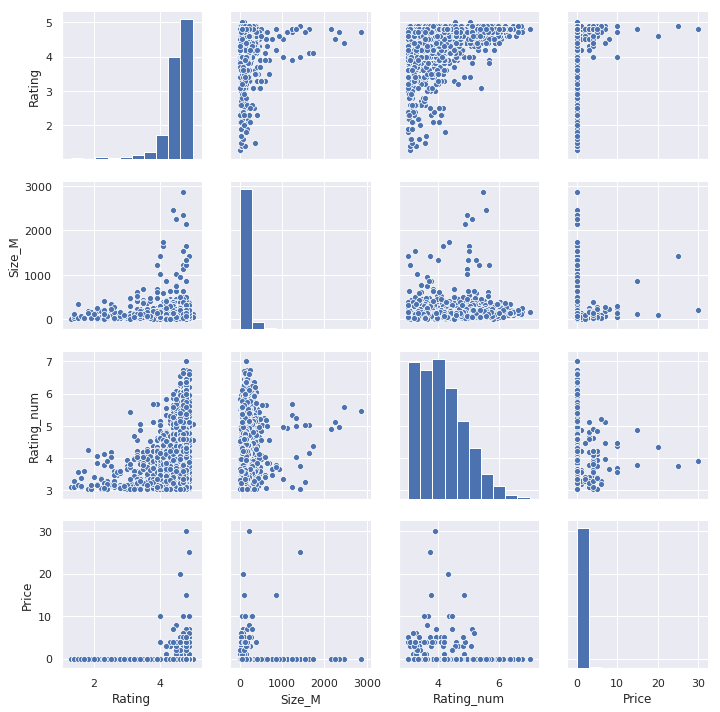

In [4]:
x = df['Rating'].dropna()
y = df['Size_M'].dropna()
#z = df['rating_count_tot'][df.Installs!=0].dropna()
p = df['Rating_num'][df.Rating_num!=0].dropna()
#t = df['Type'].dropna()
price = df['Price']

p = sns.pairplot(pd.DataFrame(list(zip(x, y, np.log10(p), price)), 
                        columns=['Rating','Size_M',  'Rating_num', 'Price']), palette="Set2")

In [5]:
number_of_apps_in_category = df['Category'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = number_of_apps_in_category.index,
        values = number_of_apps_in_category.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='active_category')

待改：
''Utilities and Game apps have the highest market prevelance.

''Social Networking, Photo & Viedo, Lifestyle and Business apps are also catching up.

In [6]:
data = [go.Histogram(
        x = df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5}
)]

print('Average app rating = ', np.mean(df['Rating']))
plotly.offline.iplot(data, filename='overall_rating_distribution')

Average app rating =  4.506265586034912


Best performing categories

In [7]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 170).reset_index()
#print(type(groups.item.['BUSINESS']))
print('Average rating = ', np.nanmean(list(groups.Rating)))
#print(len(groups.loc[df.Category == 'DATING']))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 720, len(set(groups.Category)))]


#df_sorted = df.groupby('Category').agg({'Rating':'median'}).reset_index().sort_values(by='Rating', ascending=False)
#print(df_sorted)

layout = {'title' : 'App ratings across major categories',
        'xaxis': {'tickangle':-40},
        'yaxis': {'title': 'Rating'},
          'plot_bgcolor': 'rgb(250,250,250)',
          'shapes': [{
              'type' :'line',
              'x0': -.5,
              'y0': np.nanmean(list(groups.Rating)),
              'x1': 19,
              'y1': np.nanmean(list(groups.Rating)),
              'line': { 'dash': 'dashdot'}
          }]
          }

data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'violin',
    'name' : category,
    'showlegend':False,
    #'marker': {'color': 'Set2'},
    } for i,category in enumerate(list(set(groups.Category)))]



plotly.offline.iplot({'data': data, 'layout': layout})

Average rating =  4.487341772151899


Sizing Strategy - Light Vs Bulky? How do app sizes impact the app rating?

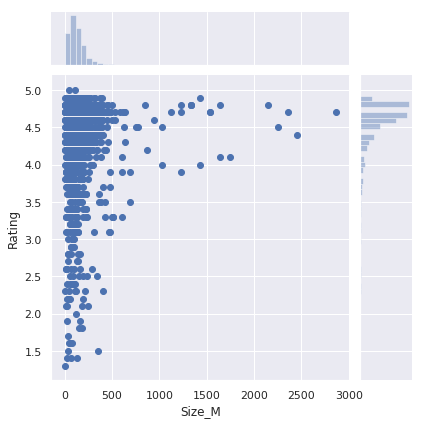

In [8]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 50).reset_index()

# sns.set_style('ticks')
# fig, ax = plt.subplots()
# fig.set_size_inches(8, 8)
sns.set_style("darkgrid")
ax = sns.jointplot(df['Size_M'], df['Rating'])
#ax.set_title('Rating Vs Size')

In [9]:
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(list(set(groups.Category))))]

subset_df = df[df.Size_M > 40]
groups_temp = subset_df.groupby('Category').filter(lambda x: len(x) >20)

#for category in enumerate(list(set(groups_temp.Category))):
#     print (category)

data = [{
    'x': groups_temp.loc[subset_df.Category==category[1]]['Rating'], 
    'type':'scatter',
    'y' : subset_df['Size_M'],
    'name' : str(category[1]),
    'mode' : 'markers',
    'showlegend': True,
    #'marker': {'color':c[i]}
    #'text' : df['rating'],
    } for category in enumerate(list(set(groups_temp.Category)))]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

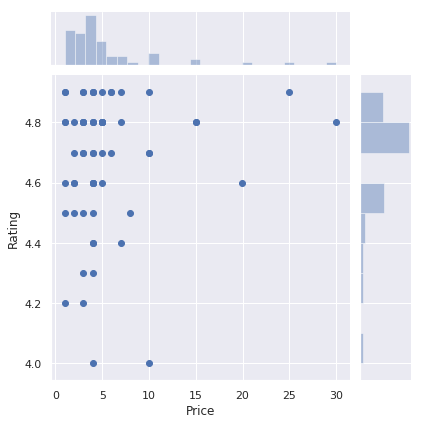

In [10]:
paid_apps = df[df.Price>0]
p = sns.jointplot( "Price", "Rating", paid_apps)

In [11]:
trace0 = go.Box(
    y=np.log10(df['Rating_num'][df.Type=='Paid']),
    name = 'Paid',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )

)
trace1 = go.Box(
    y=np.log10(df['Rating_num'][df.Type=='Free']),
    name = 'Free',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
layout = go.Layout(
    title = "Number of downloads of paid apps Vs free apps",
    yaxis= {'title': 'Number of downloads (log-scaled)'}
)
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

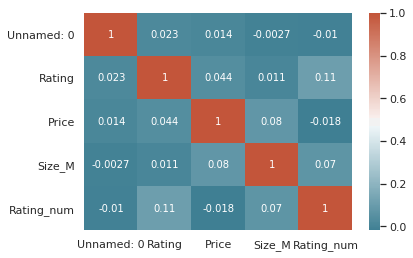

In [13]:
#df['Installs'].corr(df['Reviews'])#df['Insta 
#print(np.corrcoef(l, rating))
#df = df.drop(columns = 'Index')
corrmat = df.corr()
#f, ax = plt.subplots()
p =sns.heatmap(corrmat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))